In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Normalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

In [2]:
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

Load data


In [3]:
# Carregar o CSV
df = pd.read_csv("dados_reais_e_simulados.csv", sep=";", decimal=".", dtype=float)
df.head()

,vel,FRH,RRH,vol_pos,AoD,AoT,ClA,CdA,Cpz,DD,DE,m
0,36.388116,40.324819,47.620792,-12.749703,0.993837,0.753301,2.862229,1.319733,160.348,13.231,13.231,56.831
1,37.531006,52.075444,47.519999,5.628627,1.739537,1.479083,2.946743,1.383392,151.794,13.861,13.861,70.544
2,41.261859,43.545078,44.095291,-7.668691,-0.407964,0.236992,2.902311,1.287926,168.855,10.793,10.793,71.502
3,41.503753,44.698525,49.650558,-5.663685,1.558956,1.002525,2.920256,1.344202,176.472,14.595,14.595,78.007
4,44.821902,42.713296,43.402069,3.083435,1.000266,0.226274,2.904481,1.311804,188.754,13.405,13.405,90.632


Pre Processing

In [4]:
inputs = ["vel", "FRH", "RRH", "vol_pos", "AoD", "AoT"]
outputs = ["ClA", "CdA", "Cpz", "DD", "DE", "m"]

# Definir os dados de entrada e saída
x = df[inputs].values
y = df[outputs].values

# Normalizar os dados de saída
y_scaler = StandardScaler()
y_scaler.fit(y)
y_scaled = y_scaler.transform(y)

print(x.shape)
print(y.shape)

(99, 6)
(99, 6)


Train Model

In [ ]:
# Função para criar o modelo
def create_model(x_train, output_dim):
    x_norm = Normalization()
    x_norm.adapt(x_train)

    model = Sequential(
        [
            x_norm,
            Dense(40, activation="relu", kernel_regularizer=l2(0.001)),
            Dropout(0.1),
            Dense(60, activation="relu", kernel_regularizer=l2(0.001)),
            Dropout(0.1),
            Dense(40, activation="relu"),
            Dense(output_dim),
        ]
    )

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae", "mse", "r2_score"])

    return model

In [6]:
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, r2, mae


def compute_ci(scores):
    """Calcula e imprime a média e o intervalo de confiança de 95%."""
    mean = np.mean(scores)

    n = len(scores)
    confidence_interval = stats.t.interval(0.95, df=n - 1, loc=mean, scale=stats.sem(scores))
    return mean, confidence_interval

In [7]:
# K-Fold cross-validation
test_sizes = [0.5, 0.4, 0.3, 0.2, 0.1]
n_splits = 30

results = {
    "mse": {"train_means": [], "train_cis": [], "test_means": [], "test_cis": []},
    "r2": {"train_means": [], "train_cis": [], "test_means": [], "test_cis": []},
    "mae": {"train_means": [], "train_cis": [], "test_means": [], "test_cis": []},
}

for test_size in tqdm(test_sizes):
    mse_train_scores, r2_train_scores, mae_train_scores = [], [], []
    mse_test_scores, r2_test_scores, mae_test_scores = [], [], []

    kf = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    for fold, (train_index, val_index) in tqdm(enumerate(kf.split(x)), total=n_splits):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y_scaled[train_index], y_scaled[val_index]

        # Criar modelo
        model = create_model(x_train, output_dim=len(outputs))

        callbacks = [
            EarlyStopping(monitor="val_loss", mode="max", patience=20, restore_best_weights=True, verbose=0),
            ModelCheckpoint(
                filepath=os.path.join(model_dir, f"model_fold{fold + 1}.keras"),
                monitor="val_loss",
                save_best_only=True,
                verbose=0,
            ),
        ]

        hist = model.fit(
            x_train,
            y_train,
            batch_size=8,
            epochs=200,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=0,
            shuffle=True,
        )

        # Avaliação
        mse_train, r2_train, mae_train = compute_metrics(y_train, model.predict(x_train, verbose=0))
        mse_test, r2_test, mae_test = compute_metrics(y_val, model.predict(x_val, verbose=0))

        mse_train_scores.append(mse_train)
        r2_train_scores.append(r2_train)
        mae_train_scores.append(mae_train)
        mse_test_scores.append(mse_test)
        r2_test_scores.append(r2_test)
        mae_test_scores.append(mae_test)

    mean, ci = compute_ci(mse_train_scores)
    results["mse"]["train_means"].append(mean)
    results["mse"]["train_cis"].append(ci)

    mean, ci = compute_ci(r2_train_scores)
    results["r2"]["train_means"].append(mean)
    results["r2"]["train_cis"].append(ci)

    mean, ci = compute_ci(mae_train_scores)
    results["mae"]["train_means"].append(mean)
    results["mae"]["train_cis"].append(ci)

    mean, ci = compute_ci(mse_test_scores)
    results["mse"]["test_means"].append(mean)
    results["mse"]["test_cis"].append(ci)

    mean, ci = compute_ci(r2_test_scores)
    results["r2"]["test_means"].append(mean)
    results["r2"]["test_cis"].append(ci)

    mean, ci = compute_ci(mae_test_scores)
    results["mae"]["test_means"].append(mean)
    results["mae"]["test_cis"].append(ci)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [11]:
def plot_results(test_sizes, train_means, train_cis, test_means, test_cis, metric_name):
    """
    Plota os resultados de treino e teste com seus intervalos de confiança.
    """
    # Extrai os limites inferior e superior do intervalo de confiança
    train_ci_lower = [ci[0] for ci in train_cis]
    train_ci_upper = [ci[1] for ci in train_cis]
    test_ci_lower = [ci[0] for ci in test_cis]
    test_ci_upper = [ci[1] for ci in test_cis]

    plt.style.use("seaborn-v0_8-whitegrid")  # Estilo do gráfico
    fig, ax = plt.subplots(figsize=(12, 7))

    # --- Plot de TREINO ---
    ax.plot(test_sizes, train_means, "o-", color="royalblue", label="Média de Treino")
    ax.fill_between(test_sizes, train_ci_lower, train_ci_upper, color="royalblue", alpha=0.2, label="IC 95% Treino")

    # --- Plot de TESTE ---
    ax.plot(test_sizes, test_means, "s-", color="darkorange", label="Média de Teste")
    ax.fill_between(test_sizes, test_ci_lower, test_ci_upper, color="darkorange", alpha=0.2, label="IC 95% Teste")

    # --- Configurações do Gráfico ---
    ax.set_title(f"Desempenho do Modelo vs. Test Size ({metric_name})", fontsize=16, pad=20)
    ax.set_ylabel(f"Valor da Métrica ({metric_name})", fontsize=12)
    ax.set_xlabel("Tamanho do Conjunto de Teste (Test Size)", fontsize=12)

    # Inverte o eixo X para que o tamanho do treino aumente da esquerda para a direita
    ax.invert_xaxis()
    ax.legend(fontsize=11)

    # Adiciona um texto explicativo
    fig.text(
        0.5,
        0.01,
        "Nota: O tamanho do conjunto de treino aumenta da esquerda para a direita (50% -> 90%)",
        ha="center",
        fontsize=10,
        style="italic",
    )

    plt.show()

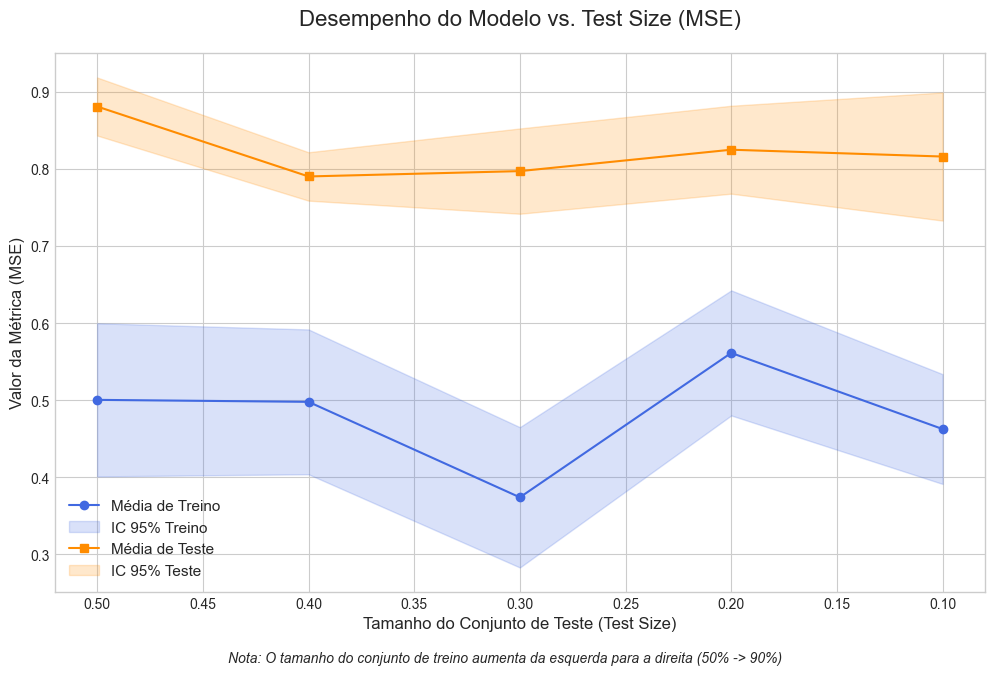

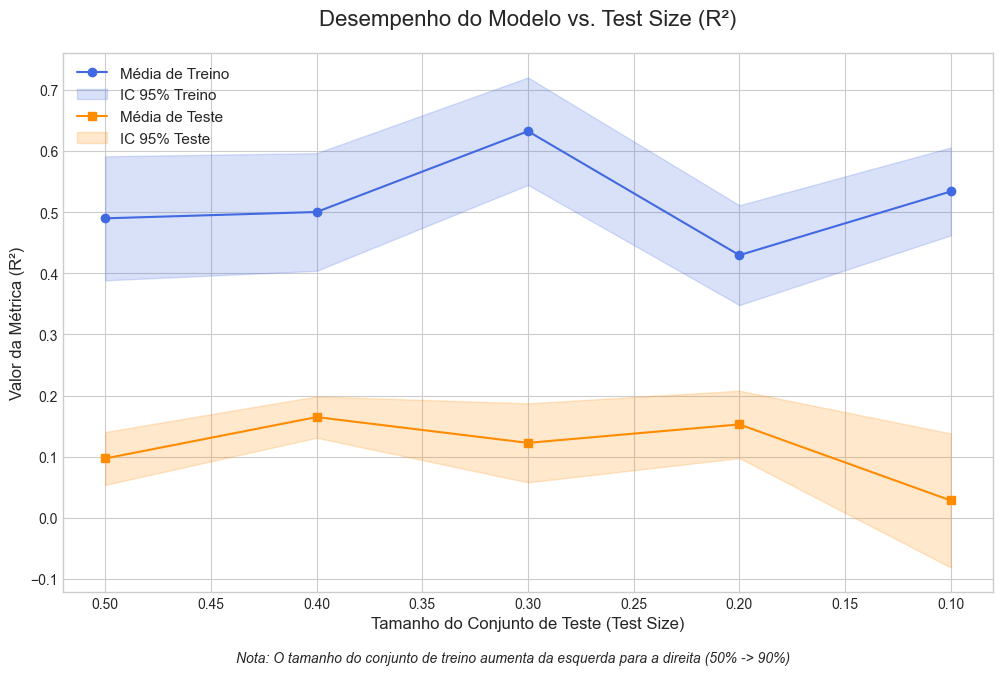

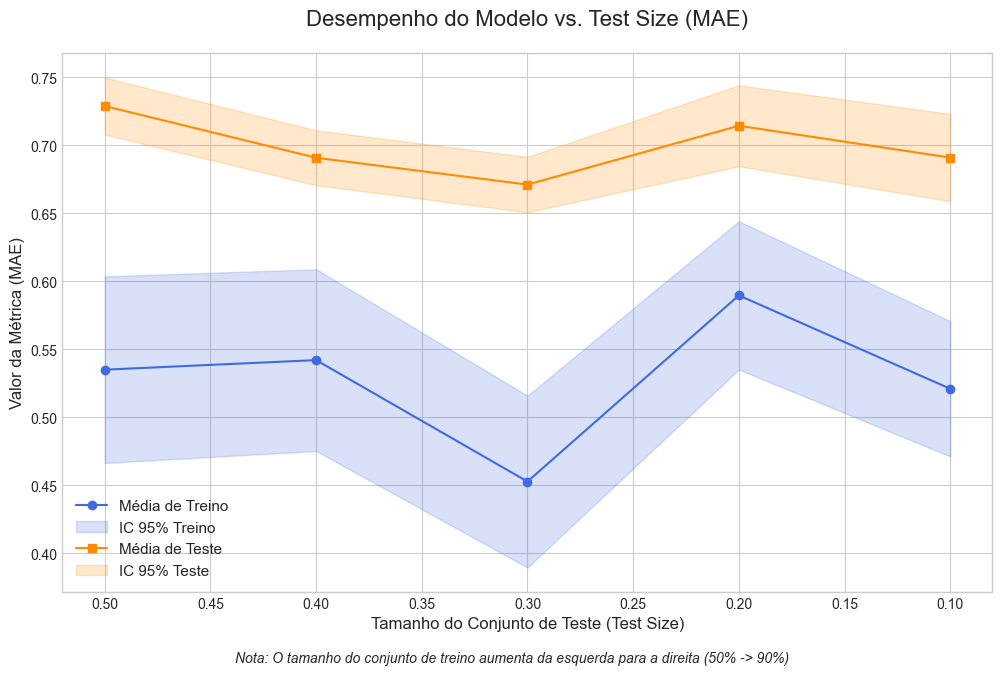

In [12]:
plot_results(
    test_sizes,
    results["mse"]["train_means"],
    results["mse"]["train_cis"],
    results["mse"]["test_means"],
    results["mse"]["test_cis"],
    "MSE",
)

# Plotar para R²
plot_results(
    test_sizes,
    results["r2"]["train_means"],
    results["r2"]["train_cis"],
    results["r2"]["test_means"],
    results["r2"]["test_cis"],
    "R²",
)

# Plotar para MAE
plot_results(
    test_sizes,
    results["mae"]["train_means"],
    results["mae"]["train_cis"],
    results["mae"]["test_means"],
    results["mae"]["test_cis"],
    "MAE",
)

ENSEMBLE PREDICTIONS

In [13]:
from tensorflow.keras.models import load_model
import numpy as np

models = [load_model(f"models/model_fold{i + 1}.keras") for i in range(k)]


def predict_with_ensemble(x_input):
    preds = [model.predict(x_input) for model in models]
    return np.mean(preds, axis=0)  # média das previsões

NameError: name 'k' is not defined

In [ ]:
# model = Sequential([
#     x_norm,
#     Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
#     Dropout(0.1),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
#     Dropout(0.1),
#     Dense(32, activation='relu'),
#     Dense(len(outputs))
# ])

# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
# model.summary()

# # Callbacks com validação
# callbacks = [
#     EarlyStopping(monitor="val_loss", mode="min", patience=500, restore_best_weights=True, verbose=1),
#     ModelCheckpoint(filepath=r"C:\Users\pc\OneDrive\Documentos\Fórmula\Mpa\Mapa\Mapa 2025\Códigos\model1.keras", monitor="val_loss", save_best_only=True, verbose=1),
# ]

# # Treinamento com divisão de validação
# hist = model.fit(
#     x, y_scaled,
#     batch_size=64,
#     epochs=2000,
#     validation_split=0.2,  # Essa linha ativa a validação automática
#     callbacks=callbacks,
#     verbose=1,
#     shuffle=True
# )

In [ ]:
# plt.plot(hist.history["val_loss"])

In [ ]:
# y1_pred_scaled = model.predict(x1)
# y1_pred = y_scaler.inverse_transform(y1_pred_scaled)
# y1_real = y1  # já está em escala original

# # Exemplo de métrica
# from sklearn.metrics import mean_absolute_error
# print("MAE no teste:", mean_absolute_error(y1_real, y1_pred))

# # Predição nos dados de teste
# y1_pred_scaled = model.predict(x1)
# y1_pred = y_scaler.inverse_transform(y1_pred_scaled)

# # Avaliar erro
# from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

# print("MAE:", mean_absolute_error(y1, y1_pred))
# print("RMSE:", root_mean_squared_error(y1, y1_pred))
# print("R²:", r2_score(y1, y1_pred))

METRICS

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

vars_y_true = np.hsplit(y_scaled, len(outputs))
vars_y_pred = np.hsplit(predict_with_ensemble(x), len(outputs))

metrics = dict(mse=mean_squared_error, mae=mean_absolute_error, r2=r2_score)

for y_true, y_pred, name in zip(vars_y_true, vars_y_pred, outputs):
    y_true = y_true.ravel()  # Flatten to 1D
    y_pred = y_pred.ravel()  # Flatten to 1D
    for metric_name, metric_fn in metrics.items():
        print(f"{name} - {metric_name}: {metric_fn(y_true, y_pred):.3f}")
    print()

In [ ]:
# vars_y1_true = np.hsplit(y1_scaled, len(outputs))
# vars_y1_pred = np.hsplit(model.predict(x1), len(outputs))

# metrics = dict(mse=mean_squared_error, mae=mean_absolute_error, r2=r2_score)

# for y1_true, y1_pred, name in zip(vars_y1_true, vars_y1_pred, outputs):
#     y1_true = y1_true.ravel()  # Flatten to 1D
#     y1_pred = y1_pred.ravel()  # Flatten to 1D
#     for metric_name, metric_fn in metrics.items():
#         print(f"{name} - {metric_name}: {metric_fn(y1_true, y1_pred):.3f}")
#     print()

PREDICTIONS

ONE SAMPLE

In [ ]:
input_sample = x[0]
output_sample = y[0]
print("input:", input_sample)

y_pred = predict_with_ensemble(np.expand_dims(input_sample, axis=0))
y_pred = y_scaler.inverse_transform(y_pred)
print("output real:", output_sample)
print("output pred:", y_pred[0])

In [ ]:
input_sample = [60, 45.0, 40.0, 0, 0, 0]
print("input:", input_sample)

y_pred = predict_with_ensemble(np.expand_dims(input_sample, axis=0))
y_pred = y_scaler.inverse_transform(y_pred)
print("output pred:", y_pred[0])

MULTIPLE SAMPLES

In [ ]:
y_pred = predict_with_ensemble(x)
y_pred = y_scaler.inverse_transform(y_pred)

In [ ]:
df_true = pd.DataFrame(y, columns=outputs)
df_pred = pd.DataFrame(y_pred, columns=[f"{name}_pred" for name in outputs])

df_res = pd.concat([df_true, df_pred], axis=1)
df_res.to_csv("Resultados.csv", index=False)
df_res.head()

In [ ]:
# y1_pred = model.predict(x1)
# y1_pred = y_scaler.inverse_transform(y1_pred)


# df_true_test = pd.DataFrame(y1, columns=outputs)
# df_pred_test = pd.DataFrame(y1_pred, columns=[f"{name}_pred" for name in outputs])

# df_res_test = pd.concat([df_true_test, df_pred_test], axis=1)
# #df_res_test.to_csv(r"C:\Users\juans\Desktop\Fórmula\Mapa 2025\Códigos\resultados_teste.csv", index=False)
# df_res_test.head()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define número de colunas e calcula número de linhas necessárias
num_outputs = len(outputs)
cols = 3  # por exemplo, 5 gráficos por linha
rows = int(np.ceil(num_outputs / cols))

# Cria uma figura com subplots organizados
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # tamanho uniforme

# Se axes for 1D, converte para 2D para evitar erro de indexação
axes = axes.flatten()

# Plota os gráficos
for i, name in enumerate(outputs):
    ax = axes[i]
    ax.scatter(df_res[name], df_res[f"{name}_pred"], alpha=0.5)
    ax.plot([df_res[name].min(), df_res[name].max()], [df_res[name].min(), df_res[name].max()], "r--")
    ax.set_title(f"{name} vs {name}_pred")
    ax.set_xlabel(name)
    ax.set_ylabel(f"{name}_pred")

# Remove subplots vazios (se houver)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Salvar o modelo treinado
# model.save('modelo_aerodinamico.h5')

# Salvar APENAS o scaler das SAÍDAS (y)
# (Certifique-se que a variável 'scaler_y' tem esse nome no seu código)
joblib.dump(y_scaler, "scaler_y.pkl")

print("Modelo e scaler de saída foram salvos com sucesso!")